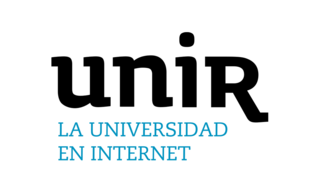

_Máster Universitario en Inteligencia Artificial_

_Trabajo Fin de Máster_

- Gustavo Mateos Santos
- gustavo.mateos830@comunidadunir.net

# Clasificación automática de estrellas variables con modelos Transformer aplicados a series temporales



In [2]:
# Install missing packages
%pip install torch lightkurve
%pip install -q pyarrow

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 13.9 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 34.0 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.7/738.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 43.1 MB/s eta 0:00:00 0:00:01
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11428 sha256=7a1c0c198fcd5b6d325211ca045f7e490a1f57d14f4fd405ac819d3c8488574e
  Stored in directory: /home/ec2-user/.cache/pip/wheels/3c/ea/60/8d1c9fbbc99492a1775b36a5e29c8c1ef309cc5821bd5a219d
  Created wheel for memoization: filen

In [3]:
import torch, lightkurve as lk

print("Torch:", torch.__version__)
print("Lightkurve:", lk.__version__)

Torch: 2.2.2
Lightkurve: 2.5.0


| Fuente       | Misión | Etiquetado | Tipo         | Método de acceso                   |
| ------------ | ------ | ---------- | ------------ | ---------------------------------- |
| Kepler EB    | Kepler | Sí         | Binaries     | NASA Exoplanet Archive / Villanova |
| K2VARCAT     | K2     | Sí         | Multiclase   | MAST HLSP                          |
| TESS-SVC     | TESS   | Semi       | Variabilidad | MAST HLSP                          |
| TESS-EB      | TESS   | Sí         | EB continuas | MAST HLSP                          |
| VSX (AAVSO)  | Todos  | Sí         | Multiclase   | AAVSO + MAST                       |
| Gaia DR3 Var | Todos  | Sí         | Multiclase   | ESA Gaia Archive                   |

Diseño del esquema del dataset. Vamos a unificar las curvas descargadas en un dataset estructurado tipo CSV/Parquet con este esquema mínimo:

| id\_mision | id\_objeto | mision | clase\_variable | fecha\_inicio | fecha\_fin | tiempo | magnitud | error | origen\_etiqueta |
| ---------- | ---------- | ------ | --------------- | ------------- | ---------- | ------ | -------- | ----- | ---------------- |

Estrategia de implementación técnica
Podemos hacerlo en varias etapas:

- Script 1: descarga de curvas etiquetadas de Kepler EB y TESS-EB (usando ID + clase desde CSV original)
- Script 2: procesamiento de K2VARCAT (CSV disponible con clase + ID)
- Script 3: combinación cruzada entre TIC (TESS Input Catalog) y VSX (requiere posiciones celestes + nombre)
- Script 4: cruce de Gaia DR3 variables con coordenadas de Kepler/K2/TESS
- Script 5: exportación consolidada en formato CSV/Parquet final con clases normalizadas

### 📥 Script 1: descarga y consolidación de curvas de Kepler y TESS de la clase EB (entorno local o SageMaker)
Esta sección permite ejecutar el script 1, ya sea con el catálogo completo (en SageMaker) o con una muestra reducida (en local), y verificar el resultado consolidado.


In [ ]:
import warnings
import os, sys, platform
import glob
from astropy.units import UnitsWarning
from pathlib import Path

# Ignorar warnings comunes de librerías externas
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UnitsWarning)
print("🔇 Warnings silenciados: UserWarning, FutureWarning")
# Desactivar Rich para evitar problemas de compatibilidad
os.environ["RICH_NO_RICH"] = "1"

# Lanzando el script de ejemplo directamente
# !python src/script_2_k2varcat_multiclase.py.py

# Asegurarse de que el directorio 'src' esté en el path de Python
src_path = Path("src").resolve()
if src_path not in sys.path:
    sys.path.append(str(src_path))
from src.script_1_kepler_tess_eb import main as run_script_1

# Detectar entorno local/AWS y ejecutar el script
try:
    import sagemaker
    is_sagemaker = True
except ImportError:
    is_sagemaker = False

existing = len(glob.glob("/home/ec2-user/backup/data/raw/kepler/*.csv")) + len(glob.glob("/home/ec2-user/backup/data/raw/tess/*.csv"))
print(f"🗃️ Curvas ya existentes en disco: {existing}", flush=True)

# Ejecutar con la opción adecuada
if is_sagemaker:
    print("🔁 Ejecutando en SageMaker → catálogo completo")
    # Solo Kepler, solo pendientes
    run_script_1(mission="Kepler", only_pending=True)
    # Ambos, solo pendientes
    #run_script_1(mission="ALL", only_pending=True)
else:
    print("💻 Ejecutando en entorno local → catálogo de prueba")
    run_script_1(use_sample=True)

🔇 Warnings silenciados: UserWarning, FutureWarning
📁 Usando RAW_DIR: /home/ec2-user/backup/data/raw


[05/16/25 11:50:07] INFO     Found credentials from IAM Role:                                   ]8;id=329048;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=354539;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
🗃️ Curvas ya existentes en disco: 7707
🔁 Ejecutando en SageMaker → catálogo completo
[⬇] Descargando catálogos completos de Kepler y TESS...
[⬇] Descargando catálogo Kepler EB...
[📂] Cargando catálogo Kepler EB desde copia local...
[⬇] Descargando catálogo TESS EB...
[⬇] Generando CSV de entrada para descarga de curvas...
📝 CSV generado con 0 estrellas → data/lists/eb_ids.csv
[⬇] Descargando curvas de luz...

🚀 Procesando misión: Kepler (only_pending=True)
📝 CSV generado con 0 estrellas → data/lists/eb_ids_kepler_pendientes.csv
[⬇] Descargando 0 curvas en paralelo con 8 hilos...


🚀 Descargando curvas: 0it [00:00, ?it/s]


	📦 0 objetos procesados hasta ahora...
[✓] Descarga finalizada: 0 objetos procesados.
[⭢] Leyendo y fusionando curvas descargadas...


[📁] Usando 37 lotes ya existentes en /home/ec2-user/temp_batches
[⏳] Uniendo todos los lotes en /home/ec2-user/backup/processed/dataset_eb_kepler.parquet...


📚 Uniendo lotes: 100%|██████████| 37/37 [01:46<00:00,  2.88s/it]


[✅] Dataset parquet construido → /home/ec2-user/backup/processed/dataset_eb_kepler.parquet
🧹 Carpeta temporal eliminada: /home/ec2-user/temp_batches
[⭢] Fusionando metadatos (etiquetas)...
[⏱] Tiempo total: 108.39 segundos


In [ ]:
from src.utils.cleanup_raw import cleanup_raw_data

# Limpiar los datos de prueba
#cleanup_raw_data('/home/ec2-user/backup/data/raw', confirm=True)

##### 📥 Comprobación de los fichero de curvas Kepler y TESS (EB) mergeado y consolidado

##### ⚠️ Comprobación de la columna "clase_variable"

In [ ]:
import pyarrow.parquet as pq
from pathlib import Path

for name in ["kepler", "tess"]:
    path = Path(f"data/processed/dataset_eb_{name}_labeled.parquet")
    if not path.exists():
        print(f"❌ Archivo no encontrado: {path}")
        continue

    try:
        parquet_file = pq.ParquetFile(path)
        schema = parquet_file.schema_arrow
        columns = schema.names

        print(f"\n📦 {name.upper()} contiene {len(columns)} columnas:")
        print(columns)

        if "clase_variable" in columns:
            print(f"✅ 'clase_variable' está presente en {name.upper()}")
        else:
            print(f"⚠️  'clase_variable' NO está presente en {name.upper()}")
    except Exception as e:
        print(f"❌ Error leyendo {path}: {e}")



📦 KEPLER contiene 31 columnas:
['tiempo', 'magnitud', 'error', 'quality', 'timecorr', 'centroid_col', 'centroid_row', 'cadenceno', 'sap_flux', 'sap_flux_err', 'sap_bkg', 'sap_bkg_err', 'pdcsap_flux', 'pdcsap_flux_err', 'sap_quality', 'psf_centr1', 'psf_centr1_err', 'psf_centr2', 'psf_centr2_err', 'mom_centr1', 'mom_centr1_err', 'mom_centr2', 'mom_centr2_err', 'pos_corr1', 'pos_corr2', 'id_objeto', 'id_mision', 'mision', 'fecha_inicio', 'fecha_fin', 'clase_variable']
✅ 'clase_variable' está presente en KEPLER

📦 TESS contiene 30 columnas:
['tiempo', 'magnitud', 'error', 'timecorr', 'cadenceno', 'centroid_col', 'centroid_row', 'sap_flux', 'sap_flux_err', 'sap_bkg', 'sap_bkg_err', 'pdcsap_flux', 'pdcsap_flux_err', 'quality', 'psf_centr1', 'psf_centr1_err', 'psf_centr2', 'psf_centr2_err', 'mom_centr1', 'mom_centr1_err', 'mom_centr2', 'mom_centr2_err', 'pos_corr1', 'pos_corr2', 'id_objeto', 'id_mision', 'mision', 'fecha_inicio', 'fecha_fin', 'clase_variable']
✅ 'clase_variable' está presen

### ✅ FIX de la columna "clase_variable"

In [ ]:
from pathlib import Path
import pyarrow.dataset as ds
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm

def reparar_parquet_streaming(parquet_path: Path, output_path: Path, clase_default: str = "EB"):
    dataset = ds.dataset(parquet_path, format="parquet")

    # Preparamos el escritor con el esquema extendido
    sample_batch = next(dataset.to_batches(batch_size=100))
    schema_original = sample_batch.schema
    schema_nueva = schema_original.append(pa.field("clase_variable", pa.string()))

    writer = pq.ParquetWriter(output_path, schema=schema_nueva, compression="snappy")

    print(f"[🔧] Reparando parquet: {parquet_path.name}")
    fragmentos = dataset.to_batches(batch_size=50000)

    for batch in tqdm(fragmentos, desc="🛠️ Reparando por lotes"):
        n = batch.num_rows
        columna_clase = pa.array([clase_default] * n, type=pa.string())
        batch_corregido = batch.append_column("clase_variable", columna_clase)
        writer.write_table(pa.Table.from_batches([batch_corregido], schema=schema_nueva))

    writer.close()
    print(f"[✅] Reparación completada → {output_path}")

# Ejemplo de uso:
reparar_parquet_streaming(Path("data/processed/dataset_eb_tess.parquet"),
                          Path("data/processed/dataset_eb_tess_labeled.parquet"))

[🔧] Reparando parquet: dataset_eb_tess.parquet


🛠️ Reparando por lotes: 2426it [10:19,  3.91it/s]


[✅] Reparación completada → data\processed\dataset_eb_tess_labeled.parquet


### 📥 Script 2: descarga y consolidación de curvas de K2 (multiclase) (entorno local o SageMaker)
Esta sección permite ejecutar el script 2, ya sea con el catálogo completo (en SageMaker) o con una muestra reducida (en local), y verificar el resultado consolidado.

| Posición | Nombre          | Descripción                                                                   |
| -------- | --------------- | ----------------------------------------------------------------------------- |
| 0        | `EPIC_ID`       | Identificador del catálogo EPIC                                               |
| 1        | `K2_TYPE`       | Tipo de curva: EB, AP, QP, P                                                  |
| 2        | `RANGE_PCT`     | Rango de la curva de luz (en %)                                               |
| 3        | `PERIOD_DAYS`   | Periodo estimado (días). 0 para sistemas aperiódicos                          |
| 4        | `AMPLITUDE_PCT` | Amplitud (en %), interpretada según el tipo                                   |
| 5        | `PROPOSAL_INFO` | Texto libre con número de propuesta y/o tipo de variable                      |
| 6        | `AMP_ERR1`      | Sin descripción clara — puede ser un valor derivado técnico (puede ignorarse) |
| 7        | `AMP_ERR2`      | Ídem                                                                          |


Aunque search_lightcurve() encuentra resultados, estos están en un formato no compatible con las versiones actuales de Lightkurve (que está diseñado para los productos SPOC y algunos QLP).
En resumen:
Los datos de K2VARCAT en MAST existen.
Pero no se pueden abrir ni procesar directamente con Lightkurve, ni con .download() ni con .download_all().

- Usar EPIC_ID + clase del CSV de K2VARCAT.
- Buscar curvas reales usando author="EVEREST" (sí compatibles con Lightkurve).
- Descargar y procesar curvas para esos objetos.
- Guardar todo en formato .parquet con esquema estándar.

In [1]:
import warnings
import os, sys
import glob
from astropy.units import UnitsWarning
from pathlib import Path

# Ignorar warnings comunes de librerías externas
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UnitsWarning)
print("🔇 Warnings silenciados: UserWarning, FutureWarning")
# Desactivar Rich para evitar problemas de compatibilidad
os.environ["RICH_NO_RICH"] = "1"

# Lanzando el script de ejemplo directamente
# !python src/script_2_k2varcat_multiclase.py.py

# Asegurarse de que el directorio 'src' esté en el path de Python
src_path = Path("src").resolve()
if src_path not in sys.path:
    sys.path.append(str(src_path))
from src.script_2_k2varcat_everest import main as run_script_2

# Detectar entorno local/AWS y ejecutar el script
try:
    import sagemaker
    is_sagemaker = True
except ImportError:
    is_sagemaker = False

if is_sagemaker:
    print("🔁 Ejecutando en SageMaker → catálogo completo")
    run_script_2(limit=None, workers=10)
else:
    print("💻 Ejecutando en entorno local → catálogo de prueba")
    run_script_2(limit=None, workers=8)


🔇 Warnings silenciados: UserWarning, FutureWarning
💻 Ejecutando en entorno local → catálogo de prueba
✅ Catálogo ya descargado: data/raw/k2varcat_official.csv


📦 Procesando curvas EVEREST: 100%|██████████| 8395/8395 [43:51<00:00,  3.19it/s]  


Resumen de estado: {'❌': 3478, '🟡': 3024, '✅': 1893}
✅ Dataset final guardado en: data/processed/dataset_k2varcat.parquet


#### Borrado caché Lightcurve

In [4]:
import shutil
import os

# Ruta por defecto en sistemas Windows / Unix
cache_dir = os.path.expanduser("~/.lightkurve/cache")

# Intentar vaciar con método oficial de Lightkurve (si existe)
try:
    from lightkurve import clear_download_cache
    print("🧹 Limpiando caché con Lightkurve...")
    clear_download_cache()
except ImportError:
    print("⚠️ clear_download_cache no está disponible en esta versión de Lightkurve. Se eliminará manualmente.")

# Borrar carpeta cache si todavía quedan ficheros residuales
if os.path.exists(cache_dir):
    try:
        shutil.rmtree(cache_dir)
        print(f"✅ Caché eliminada: {cache_dir}")
    except Exception as e:
        print(f"⚠️ No se pudo eliminar completamente la carpeta: {e}")
else:
    print("ℹ️ No se encontró la carpeta de caché")

# Confirmación de espacio liberado (solo si quieres usarlo)
import psutil
total, used, free = shutil.disk_usage(".")
print(f"💾 Espacio libre actual: {free // (1024 ** 3)} GB")


⚠️ clear_download_cache no está disponible en esta versión de Lightkurve. Se eliminará manualmente.
✅ Caché eliminada: C:\Users\hav3f/.lightkurve/cache
💾 Espacio libre actual: 96 GB


In [ ]:
import shutil

chunks_dir = "data/processed/k2varcat_chunks"
shutil.rmtree(chunks_dir)
print(f"✅ Directorio eliminado: {chunks_dir}")


### 📥 Script 3: descarga y consolidación de curvas de K2 (multiclase) (entorno local o SageMaker)

#### 🎯 Objetivo:

Cruzar objetos del catálogo TIC (TESS Input Catalog) con el catálogo **VSX (AAVSO Variable Star Index)** para:

-   Obtener variables etiquetadas con clases del VSX.
    
-   Localizar sus posiciones celestes (RA, DEC).
    
-   Buscar sus curvas reales mediante ID TIC o coordenadas.
    
#### ✅ Fuentes necesarias:

**TIC**

ID TIC, RA/DEC, magnitudes, TESS target info

MAST via Vizier o CDS

**VSX**

Nombre variable, RA/DEC, tipo variable (EA, DSCT, RRab, etc.)

tic_dec00_00N__02_00N.csv.gz - 4.51GB

tic_dec02_00N__04_00N.csv.gz - 4.77GB

tic_dec02_00S__00_00N.csv.gz - 5.04GB

tic_dec04_00N__06_00N.csv.gz - 4.57GB

tic_dec04_00S__02_00S.csv.gz - 4.40GB

tic_dec06_00N__08_00N.csv.gz - 4.65GB

tic_dec06_00S__04_00S.csv.gz - 5.01GB

tic_dec08_00N__10_00N.csv.gz - 4.87GB

tic_dec08_00S__06_00S.csv.gz - 5.51GB

tic_dec10_00N__12_00N.csv.gz - 5.09GB

tic_dec10_00S__08_00S.csv.gz - 5.40GB

tic_dec12_00N__14_00N.csv.gz - 5.03GB

tic_dec12_00S__10_00S.csv.gz - 5.40GB

tic_dec14_00N__16_00N.csv.gz - 4.94GB

tic_dec14_00S__12_00S.csv.gz - 5.90GB

tic_dec16_00N__18_00N.csv.gz - 4.76GB

tic_dec16_00S__14_00S.csv.gz - 6.93GB

tic_dec18_00N__20_00N.csv.gz - 4.77GB

tic_dec18_00S__16_00S.csv.gz - 7.79GB

tic_dec20_00S__18_00S.csv.gz - 7.99GB

**TOTAL: 107 GB**

In [1]:
import warnings
import os, sys
import glob
from astropy.units import UnitsWarning
from pathlib import Path

# Ignorar warnings comunes de librerías externas
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UnitsWarning)
print("🔇 Warnings silenciados: UserWarning, FutureWarning")
# Desactivar Rich para evitar problemas de compatibilidad
os.environ["RICH_NO_RICH"] = "1"

# Lanzando el script de ejemplo directamente
# !python src/script_2_k2varcat_multiclase.py.py

# Asegurarse de que el directorio 'src' esté en el path de Python
src_path = Path("src").resolve()
if src_path not in sys.path:
    sys.path.append(str(src_path))
from src.script_3_vsx_tic_match import main as run_script_3

# Detectar entorno local/AWS y ejecutar el script
try:
    import sagemaker
    is_sagemaker = True
except ImportError:
    is_sagemaker = False

if is_sagemaker:
    print("🔁 Ejecutando en SageMaker → catálogo completo")
    run_script_3(limit=None, radio_arcsec=3.0, limit_bins=5)
else:
    print("💻 Ejecutando en entorno local → catálogo completo")
    run_script_3(limit=5000, radio_arcsec=3.0, limit_bins=30, max_download_workers=4)


🔇 Warnings silenciados: UserWarning, FutureWarning
💻 Ejecutando en entorno local → catálogo completo
📉 Catálogo VSX reducido a franja DEC -20 → 20 (3900 objetos)
🎯 Limitando a 30 regiones DEC (bins únicos)
📦 Archivos DEC necesarios: ['tic_dec00_00N__02_00N.csv.gz', 'tic_dec02_00N__04_00N.csv.gz', 'tic_dec02_00S__00_00N.csv.gz', 'tic_dec04_00N__06_00N.csv.gz', 'tic_dec04_00S__02_00S.csv.gz', 'tic_dec06_00N__08_00N.csv.gz', 'tic_dec06_00S__04_00S.csv.gz', 'tic_dec08_00N__10_00N.csv.gz', 'tic_dec08_00S__06_00S.csv.gz', 'tic_dec10_00N__12_00N.csv.gz', 'tic_dec10_00S__08_00S.csv.gz', 'tic_dec12_00N__14_00N.csv.gz', 'tic_dec12_00S__10_00S.csv.gz', 'tic_dec14_00N__16_00N.csv.gz', 'tic_dec14_00S__12_00S.csv.gz', 'tic_dec16_00N__18_00N.csv.gz', 'tic_dec16_00S__14_00S.csv.gz', 'tic_dec18_00N__20_00N.csv.gz', 'tic_dec18_00S__16_00S.csv.gz', 'tic_dec20_00S__18_00S.csv.gz']
🟡 Ya existe: tic_dec00_00N__02_00N.csv.gz. No se vuelve a descargar.
🟡 Ya existe: tic_dec02_00S__00_00N.csv.gz. No se vuelve a

⬇️ Descargando TIC: 100%|██████████| 20/20 [00:00<00:00, 661.85it/s]

🟡 Ya existe: tic_dec10_00N__12_00N.csv.gz. No se vuelve a descargar.🟡 Ya existe: tic_dec08_00S__06_00S.csv.gz. No se vuelve a descargar.
🟡 Ya existe: tic_dec12_00N__14_00N.csv.gz. No se vuelve a descargar.
🟡 Ya existe: tic_dec10_00S__08_00S.csv.gz. No se vuelve a descargar.

🟡 Ya existe: tic_dec12_00S__10_00S.csv.gz. No se vuelve a descargar.
🟡 Ya existe: tic_dec14_00S__12_00S.csv.gz. No se vuelve a descargar.
🟡 Ya existe: tic_dec14_00N__16_00N.csv.gz. No se vuelve a descargar.
🟡 Ya existe: tic_dec16_00S__14_00S.csv.gz. No se vuelve a descargar.
🟡 Ya existe: tic_dec16_00N__18_00N.csv.gz. No se vuelve a descargar.
🟡 Ya existe: tic_dec18_00N__20_00N.csv.gz. No se vuelve a descargar.
🟡 Ya existe: tic_dec18_00S__16_00S.csv.gz. No se vuelve a descargar.
🟡 Ya existe: tic_dec20_00S__18_00S.csv.gz. No se vuelve a descargar.


📂 Procesando en chunks tic_dec06_00N__08_00N.csv.gz...
⏱️ Chunks procesados en 389.62 s
📂 Procesando en chunks tic_dec02_00N__04_00N.csv.gz...
⏱️ Chunks procesados en 422.36 s
📂 Procesando en chunks tic_dec08_00N__10_00N.csv.gz...
⏱️ Chunks procesados en 407.71 s
📂 Procesando en chunks tic_dec02_00S__00_00N.csv.gz...
⏱️ Chunks procesados en 348.85 s
📂 Procesando en chunks tic_dec04_00S__02_00S.csv.gz...
⏱️ Chunks procesados en 304.94 s
📂 Procesando en chunks tic_dec00_00N__02_00N.csv.gz...
⏱️ Chunks procesados en 284.42 s
📂 Procesando en chunks tic_dec06_00S__04_00S.csv.gz...
⏱️ Chunks procesados en 306.23 s
📂 Procesando en chunks tic_dec04_00N__06_00N.csv.gz...
⏱️ Chunks procesados en 266.55 s
📂 Procesando en chunks tic_dec08_00S__06_00S.csv.gz...
⏱️ Chunks procesados en 336.47 s
📂 Procesando en chunks tic_dec12_00N__14_00N.csv.gz...
⏱️ Chunks procesados en 274.89 s
📂 Procesando en chunks tic_dec10_00S__08_00S.csv.gz...
⏱️ Chunks procesados en 303.38 s
📂 Procesando en chunks tic_dec10

🧮 Procesando por lotes: 1it [00:00, 55.55it/s]


✅ Resumen exportado a: data/processed/summary\dataset_vsx_tic_labeled_summary.csv


PermissionError: [WinError 5] Acceso denegado: 'data\\processed\\temp_vsx_tic'

### ℹ️ Verificación de estructura y metada

In [2]:
import pyarrow.dataset as ds
from collections import Counter
from tqdm import tqdm
import json
import csv
from datetime import datetime
import os

def inspect_and_export_summary(parquet_path, output_format="json"):
    print(f"\n📁 Inspeccionando: {parquet_path}")
    dataset = ds.dataset(parquet_path, format="parquet")
    schema = dataset.schema

    summary = {
        "file": parquet_path,
        "columns": {field.name: str(field.type) for field in schema},
        "class_distribution": {},
        "total_rows": 0,
        "total_objects": 0,
        "timestamp": datetime.now().isoformat()
    }

    class_counter = Counter()
    objetos = set()

    for batch in tqdm(dataset.to_batches(columns=["clase_variable", "id_objeto"]), desc="🧮 Procesando por lotes"):
        summary["total_rows"] += batch.num_rows
        if "clase_variable" in batch.schema.names:
            clases = batch.column("clase_variable").to_pylist()
            class_counter.update(clases)
        if "id_objeto" in batch.schema.names:
            objetos.update(batch.column("id_objeto").to_pylist())

    summary["class_distribution"] = dict(class_counter)
    summary["total_objects"] = len(objetos)

    # Salida
    output_dir = "data/processed/summary"
    os.makedirs(output_dir, exist_ok=True)
    basename = os.path.splitext(os.path.basename(parquet_path))[0]
    output_path = os.path.join(output_dir, f"{basename}_summary.{output_format}")

    if output_format == "json":
        with open(output_path, "w", encoding="utf-8") as f:
            json.dump(summary, f, indent=2, ensure_ascii=False)
    elif output_format == "csv":
        with open(output_path, "w", newline='', encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(["Clase", "Recuento"])
            for clase, count in class_counter.items():
                writer.writerow([clase, count])
        # Añadir resumen general en info.txt
        with open(output_path.replace(".csv", "_info.txt"), "w", encoding="utf-8") as f:
            f.write(f"Fichero: {summary['file']}\n")
            f.write(f"Filas totales: {summary['total_rows']}\n")
            f.write(f"Curvas únicas (id_objeto): {summary['total_objects']}\n")
            f.write(f"Columnas: {list(summary['columns'].keys())}\n")
            f.write(f"Fecha: {summary['timestamp']}\n")
    else:
        raise ValueError("❌ Formato no soportado. Usa 'json' o 'csv'.")

    print(f"✅ Resumen exportado a: {output_path}")

# 🔧 Uso de ejemplo
#inspect_and_export_summary("data/processed/dataset_eb_kepler_labeled.parquet", output_format="csv")
#inspect_and_export_summary("data/processed/dataset_eb_tess_labeled.parquet", output_format="csv")
# Inspeccionar el parquet de K2
#inspect_and_export_summary("data/processed/dataset_k2varcat_labeled.parquet", output_format="csv")
# Inspeccionar el parquet de VSX-TIC-TESS
inspect_and_export_summary("data/processed/dataset_vsx_tess_labeled.parquet", output_format="csv")



📁 Inspeccionando: data/processed/dataset_vsx_tess_labeled.parquet


🧮 Procesando por lotes: 314it [03:04,  1.70it/s]

✅ Resumen exportado a: data/processed/summary\dataset_vsx_tess_labeled_summary.csv


📊 ¿Qué indica el recuento?
No representa el número de estrellas, sino la suma de todas las observaciones individuales que componen las curvas.

#### **Kepler**

| Métrica                          | Valor         |
| -------------------------------- | ------------- |
| 🔢 Filas totales (observaciones) | 71,735,011    |
| 🌟 Curvas únicas (`id_objeto`)   | 2762         |
| 🧬 Clases presentes              | EB |

71,7 millones de puntos de luz (observaciones) etiquetados como "EB" (eclipsing binary), pertenecientes a 2762 curvas de luz.

#### **TESS**

| Métrica                          | Valor         |
| -------------------------------- | ------------- |
| 🔢 Filas totales (observaciones) | 120,747,997    |
| 🌟 Curvas únicas (`id_objeto`)   | 4142         |
| 🧬 Clases presentes              | EB |
 
120,7 millones de observaciones etiquetadas como "EB", pertenecientes a 4142 curvas de luz.

#### **K2**

| Métrica                          | Valor         |
| -------------------------------- | ------------- |
| 🔢 Filas totales (observaciones) | 17,895,159    |
| 🌟 Curvas únicas (`id_objeto`)   | 4917         |
| 🧬 Clases presentes              | AP, QP, P, EB |

17,8 millones de observaciones etiquetadas multiclase, pertenecientes a 4917 curvas de luz.

Distribución de clases: 

| Clase | Observaciones |
| ----- | ------------- |
| AP    | 9,884,704     |
| QP    | 7,344,096     |
| P     | 433,803       |
| EB    | 232,556       |

NOTA: la clase `EB`, que no estaba en el subconjunto reducido pero sí aparece en el total, lo cual valida que el catálogo completo contiene ejemplos de todas las clases previstas.

#### **VSX <> TIC**


-   **Total de coincidencias**: 3989
-   **Objetos únicos**: 3879 → solo hay unos pocos objetos duplicados (esperable si hay múltiples matches por posición con el mismo `id_objeto` VSX)
-   **Columnas correctas**: identificadores, posición cruzada, tipo de variable y fuente.

📊 Distribución de clases

-   El sistema ha capturado una gran variedad de clases reales como:  
    -   `ROT`, `RRAB`, `DSCT`, `RS`, `EA`, `EW`, `EB`, `GDOR`, `ACV`, etc.
-   Hay algunas clases **ambiguas o sin limpiar**, como:
    -   Compuestos (`DSCT|GDOR|SXPHE`, `ESD|EC`)
    -   Vacíos: `''` → 16 filas
    -   Etiquetas complejas (más de 3 clases unidas por `|`)

🔁 Esto es habitual en VSX, y podrás **normalizar esas clases** para agrupar mejor.

✅ `dataset_vsx_tic_labeled.parquet` es un **catálogo cruzado** que contiene:

* Estrellas variables identificadas en VSX
* Posiciones (RA/DEC) y tipos de variabilidad (`clase_variable`)
* Su correspondiente `tic_id` en el catálogo TIC

🚫 Pero **no contiene curvas de luz**, a diferencia de tus datasets previos de Kepler, K2 y TESS.

🧭 Por tanto, los **pasos siguientes correctos** son:

#### ✅ 1. Limpieza y consolidación de clases (`clase_variable`)

* VSX usa nomenclaturas complejas: combinaciones (`DSCT|GDOR|SXPHE`), ambigüedades (`VAR`, `MISC`) y valores vacíos.
* Necesitas definir una taxonomía unificada (por ejemplo, agrupar todos los `RR*` en `RR Lyrae`, o filtrar `UNKNOWN`).
* Resultado: una columna `clase_variable_normalizada` útil para clasificación supervisada.

👉 Esto se puede hacer ya sobre el `.parquet` actual sin descargar nada más.

#### ✅ 2. Usar `tic_id` para descargar curvas reales de TESS

* Usas `Lightkurve` o MAST para buscar y descargar curvas de luz (`PDCSAP_FLUX`) por `tic_id`.
* Construyes un nuevo `.parquet` que **sí contendrá curvas reales** (tiempo, magnitud, error...).
* Este será tu dataset VSX-TESS etiquetado real.

👉 Esto será el que puedes fusionar con Kepler, K2 y TESS ya procesados. **...Eso es lo que hemos hecho (ver celda abajo con llamada a `script_3a_clean_vsx_classes`) y tenemos**: 

##### 📌 `dataset_vsx_tess_labeled.parquet`

#### **VSX <> TIC** => TESS

| Métrica                          | Valor         |
| -------------------------------- | ------------- |
| 🔢 Filas totales (observaciones) | 41,1 millones    |
| 🌟 Curvas únicas (`id_objeto`)   | 1594         |
| 🧬 Clases presentes              | múltiples |
| 🟢 Columnas              | tiempo, magnitud, error, clase_variable, etc. |


📊 Distribución de clases
✅ Cosas correctas:
- Las clases originales del catálogo VSX han sido conservadas.
- Muchas de ellas fueron etiquetadas por patrones múltiples (DSCT|GDOR|SXPHE, EC|ESD, etc.).
- Existen clases ya normalizadas como ROT, EA, RS, EB, RRAB…
- La clase vacía , se ha detectado como tal y separada (468006 filas): podemos limpiar eso después si hace falta.





In [1]:
from src.script_3a_clean_vsx_classes import main as run_normalization
run_normalization()

📥 Leyendo: data/processed/dataset_vsx_tic_labeled.parquet
🔧 Normalizando clases...
🔎 Clases únicas encontradas: 33
💾 Guardando dataset limpio en: data/processed/dataset_vsx_tic_labeled_clean.parquet
📊 Exportando resumen de clases...
✅ Proceso completado


In [2]:
import warnings
import os, sys
import glob
from astropy.units import UnitsWarning
from pathlib import Path

# Ignorar warnings comunes de librerías externas
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UnitsWarning)
print("🔇 Warnings silenciados: UserWarning, FutureWarning")
# Desactivar Rich para evitar problemas de compatibilidad
os.environ["RICH_NO_RICH"] = "1"

# Asegurarse de que el directorio 'src' esté en el path de Python
src_path = Path("src").resolve()
if src_path not in sys.path:
    sys.path.append(str(src_path))
from src.script_3b_download_tess_curves_from_vsx import main as run_vsx_tess_download

# Detectar entorno local/AWS y ejecutar el script
try:
    import sagemaker
    is_sagemaker = True
except ImportError:
    is_sagemaker = False

if is_sagemaker:
    print("🔁 Ejecutando en SageMaker → catálogo completo")
    run_vsx_tess_download(limit=None, workers=4)
else:
    print("💻 Ejecutando en entorno local → catálogo completo")
    run_vsx_tess_download(limit=None, workers=8)


🔇 Warnings silenciados: UserWarning, FutureWarning
💻 Ejecutando en entorno local → catálogo completo
📥 Cargando dataset: data/processed/dataset_vsx_tic_labeled.parquet


100%|██████████| 3987/3987 [12:00:11<00:00, 10.84s/it]  


✅ Guardados 41143597 registros en parquet temporales.
📦 Unificando resultados...
✅ Dataset final guardado en: data/processed/dataset_vsx_tess_labeled.parquet (41143597 filas)

📁 Inspeccionando: data/processed/dataset_vsx_tess_labeled.parquet


NameError: name 'ds' is not defined

In [ ]:
# NORMALIZACION DE CLASES EN EL FICHERO FINAL DE ESTE SCRIPT

from src.script_3c_clean_vsx_tess_classes import limpiar_dataset, inspect_and_export_summary

path = limpiar_dataset()
inspect_and_export_summary(path, output_format="csv")


📥 Leídas 41143597 filas desde data/processed/dataset_vsx_tess_labeled.parquet
✅ Guardado dataset limpio en: data/processed/dataset_vsx_tess_labeled_clean.parquet

📁 Inspeccionando: data/processed/dataset_vsx_tess_labeled_clean.parquet


🧮 Procesando por lotes: 314it [03:52,  1.35it/s]

✅ Resumen exportado a: data/processed/summary\dataset_vsx_tess_labeled_clean_summary.csv


| Clase        | Recuento        |
| ------------ | --------------- |
| Rotational   | 26.2 millones ✅ |
| Eclipsing    | 3.1 millones ✅  |
| Delta\_Scuti | 2.9 millones ✅  |
| RS\_CVn      | 1.7 millones ✅  |
| RR\_Lyrae    | 427 mil ✅       |
| Cataclysmic  | 535 mil ✅       |
| White\_Dwarf | 219 mil ✅       |
| Irregular    | 3.6 millones ✅  |
| BY\_Dra      | 277 mil ✅       |
| Beta\_Cep    | 181 mil ✅       |
| YSO          | 138 mil ✅       |
| RARE         | 1.17 millones ✅ |
| UNKNOWN      | 468 mil ⚠️      |


#### ✅ 3. Script 4: cruce con Gaia DR3

Este paso (cruce por coordenadas) tendrá más sentido cuando tengas todo lo anterior consolidado.



In [ ]:
%run src/inspect_parquets_for_gaia.py


🔍 Analizando datasets para cruce con Gaia DR3:

📁 dataset_eb_kepler_labeled.parquet
🔑 Columnas detectadas: ['tiempo', 'magnitud', 'error', 'quality', 'timecorr', 'centroid_col', 'centroid_row', 'cadenceno', 'sap_flux', 'sap_flux_err', 'sap_bkg', 'sap_bkg_err', 'pdcsap_flux', 'pdcsap_flux_err', 'sap_quality', 'psf_centr1', 'psf_centr1_err', 'psf_centr2', 'psf_centr2_err', 'mom_centr1', 'mom_centr1_err', 'mom_centr2', 'mom_centr2_err', 'pos_corr1', 'pos_corr2', 'id_objeto', 'id_mision', 'mision', 'fecha_inicio', 'fecha_fin', 'clase_variable']

⚠️ Coordenadas insuficientes para cruce con Gaia
       tiempo  magnitud     error  quality  timecorr  centroid_col
0  131.512362  1.065252  0.000161        0  0.001369     860.09303
1  131.532797  0.974507  0.000158        0  0.001369     860.09343

------------------------------------------------------------

📁 dataset_eb_tess_labeled.parquet
🔑 Columnas detectadas: ['tiempo', 'magnitud', 'error', 'timecorr', 'cadenceno', 'centroid_col', 'centroid

In [1]:
%run src/script_3c_merge_coordinates_into_clean_vsx.py

📂 Cargando dataset limpio: dataset_vsx_tic_labeled_clean.parquet
📂 Cargando dataset original: dataset_vsx_tic_labeled.parquet
🧾 Columnas del original: ['id_objeto', 'nombre_vsx', 'clase_variable', 'ra', 'dec', 'tic_id', 'tic_ra', 'tic_dec', 'origen_etiqueta']
🧹 Eliminando columnas conflictivas del limpio: ['ra', 'dec', 'tic_ra', 'tic_dec']
🧭 Usando coordenadas: tic_ra → ra, tic_dec → dec
✅ Columnas finales en df_merged: ['id_objeto', 'nombre_vsx', 'clase_variable', 'tic_id', 'origen_etiqueta', 'clase_variable_normalizada', 'ra', 'dec']
⚠️ Filas sin coordenadas tras merge: 0
✅ Guardado con coordenadas: data\processed\dataset_vsx_tic_labeled_clean_with_coords.parquet (3989 filas)


In [2]:
import warnings
import os, sys
import glob
from astropy.units import UnitsWarning
from pathlib import Path

# Ignorar warnings comunes de librerías externas
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UnitsWarning)
print("🔇 Warnings silenciados: UserWarning, FutureWarning")
# Desactivar Rich para evitar problemas de compatibilidad
os.environ["RICH_NO_RICH"] = "1"

# Asegurarse de que el directorio 'src' esté en el path de Python
src_path = Path("src").resolve()
if src_path not in sys.path:
    sys.path.append(str(src_path))
from src.script_4_gaia_dr3_vsx_tic_crossmatch import main as run_gaiadr3

# Detectar entorno local/AWS y ejecutar el script
try:
    import sagemaker
    is_sagemaker = True
except ImportError:
    is_sagemaker = False

if is_sagemaker:
    print("🔁 Ejecutando en SageMaker → catálogo completo")
    run_gaiadr3(limit=None, workers=4)
else:
    print("💻 Ejecutando en entorno local → catalogo completo")
    run_gaiadr3(limit=None, workers=8)


🔇 Warnings silenciados: UserWarning, FutureWarning
💻 Ejecutando en entorno local → catalogo completo
📄 Cargando: dataset_vsx_tic_labeled_clean_fixed.parquet
📊 Total inicial: 3989
📊 Tras normalizar id_objeto: 3989
📊 Tras filtrar coordenadas válidas: 3989
📊 Final tras drop_duplicates: 3987
📦 Dataset listo: 3987 objetos únicos con coordenadas
📦 Dataset listo: 3987 objetos únicos con coordenadas
📊 Procesando dataset completo con 3987 objetos


100%|██████████| 3987/3987 [06:44<00:00,  9.85it/s]  


✅ Guardado en data\processed\dataset_gaia_dr3_vsx_tic_labeled.parquet (3987 filas)

📁 Inspeccionando: data\processed\dataset_gaia_dr3_vsx_tic_labeled.parquet


🧮 Procesando por lotes: 1it [00:00, 55.27it/s]

✅ Resumen exportado a: data\processed\summary\dataset_gaia_dr3_vsx_tic_labeled_summary.csv


#### ✅ **NORMALIZACION DE LOS ID OBJETO EN LOS DISTINTOS DATASETS**

**Objetivo**

Corregir los valores de la columna id_objeto en estos ficheros:

- dataset_eb_kepler_labeled.parquet
- dataset_eb_tess_labeled.parquet
- dataset_k2varcat_labeled.parquet
- dataset_vsx_tess_labeled.parquet

Para que cumplan esta regla:

| Misión       | Formato correcto `id_objeto` |
| ------------ | ---------------------------- |
| Kepler       | `KIC_<id>`                   |
| K2 (EVEREST) | `EPIC_<id>`                  |
| TESS         | `TIC_<id>`                   |
| VSX-TESS     | `TIC_<id>`                   |


Y eliminar sufijos .0, espacios o símbolos indeseados.



In [1]:
%run src/script_5a_normalize_ids.py --mision kepler



🔧 Procesando KEPLER → dataset_eb_kepler_labeled.parquet
📝 Procesando batch #1...
✅ Primera tanda procesada. Esquema: ['tiempo', 'magnitud', 'error', 'quality', 'timecorr', 'centroid_col', 'centroid_row', 'cadenceno', 'sap_flux', 'sap_flux_err', 'sap_bkg', 'sap_bkg_err', 'pdcsap_flux', 'pdcsap_flux_err', 'sap_quality', 'psf_centr1', 'psf_centr1_err', 'psf_centr2', 'psf_centr2_err', 'mom_centr1', 'mom_centr1_err', 'mom_centr2', 'mom_centr2_err', 'pos_corr1', 'pos_corr2', 'id_objeto', 'id_mision', 'mision', 'fecha_inicio', 'fecha_fin', 'clase_variable']
✅ Batch #1 escrito: 50000 filas
📝 Procesando batch #2...
✅ Batch #2 escrito: 50000 filas
📝 Procesando batch #3...
✅ Batch #3 escrito: 50000 filas
📝 Procesando batch #4...
✅ Batch #4 escrito: 50000 filas
📝 Procesando batch #5...
✅ Batch #5 escrito: 50000 filas
📝 Procesando batch #6...
✅ Batch #6 escrito: 50000 filas
📝 Procesando batch #7...
✅ Batch #7 escrito: 50000 filas
📝 Procesando batch #8...
✅ Batch #8 escrito: 50000 filas
📝 Procesand

In [3]:
%run src/script_5a_normalize_ids.py --mision tess


🔧 Procesando TESS → dataset_eb_tess_labeled.parquet
📝 Procesando batch #1...
✅ Batch #1 guardado en dataset_eb_tess_labeled_batch_0000.parquet (50000 filas)
📝 Procesando batch #2...
✅ Batch #2 guardado en dataset_eb_tess_labeled_batch_0001.parquet (50000 filas)
📝 Procesando batch #3...
✅ Batch #3 guardado en dataset_eb_tess_labeled_batch_0002.parquet (50000 filas)
📝 Procesando batch #4...
✅ Batch #4 guardado en dataset_eb_tess_labeled_batch_0003.parquet (50000 filas)
📝 Procesando batch #5...
✅ Batch #5 guardado en dataset_eb_tess_labeled_batch_0004.parquet (50000 filas)
📝 Procesando batch #6...
✅ Batch #6 guardado en dataset_eb_tess_labeled_batch_0005.parquet (50000 filas)
📝 Procesando batch #7...
✅ Batch #7 guardado en dataset_eb_tess_labeled_batch_0006.parquet (50000 filas)
📝 Procesando batch #8...
✅ Batch #8 guardado en dataset_eb_tess_labeled_batch_0007.parquet (50000 filas)
📝 Procesando batch #9...
✅ Batch #9 guardado en dataset_eb_tess_labeled_batch_0008.parquet (50000 filas)
📝 

In [1]:
from pyarrow import dataset as ds
import pyarrow.parquet as pq
import pyarrow as pa
from pathlib import Path

# Configuración
stem = "dataset_eb_tess_labeled_batch"
temp_dir = Path("data/processed/normalized_temp")
output_path = Path("data/processed/dataset_eb_tess_labeled_fixed.parquet")
batch_files = sorted(temp_dir.glob(f"{stem}_*.parquet"))

print(f"🔗 Unificando {len(batch_files)} batches por streaming...")

# Crear dataset de entrada
dataset = ds.dataset(batch_files, format="parquet")

# Inicializar escritor
writer = None
for i, batch in enumerate(dataset.to_batches()):
    table = pa.Table.from_batches([batch])
    if writer is None:
        writer = pq.ParquetWriter(output_path, table.schema)
    writer.write_table(table)
    if (i + 1) % 100 == 0:
        print(f"✅ {i+1} batches escritos...")

# Cerrar
if writer:
    writer.close()
    print(f"✅ Escritura completada: {output_path}")



🔗 Unificando 2426 batches por streaming...
✅ 100 batches escritos...
✅ 200 batches escritos...
✅ 300 batches escritos...
✅ 400 batches escritos...
✅ 500 batches escritos...
✅ 600 batches escritos...
✅ 700 batches escritos...
✅ 800 batches escritos...
✅ 900 batches escritos...
✅ 1000 batches escritos...
✅ 1100 batches escritos...
✅ 1200 batches escritos...
✅ 1300 batches escritos...
✅ 1400 batches escritos...
✅ 1500 batches escritos...
✅ 1600 batches escritos...
✅ 1700 batches escritos...
✅ 1800 batches escritos...
✅ 1900 batches escritos...
✅ 2000 batches escritos...
✅ 2100 batches escritos...
✅ 2200 batches escritos...
✅ 2300 batches escritos...
✅ 2400 batches escritos...
✅ Escritura completada: data\processed\dataset_eb_tess_labeled_fixed.parquet


In [ ]:
%run src/script_5a_normalize_ids.py --mision k2

# Ejecutado en otro notebook

In [ ]:
%run src/script_5a_normalize_ids.py --mision vsx_tess

# Ejecutado en otro notebook

#### ✅ **Verificación estructural completa de todos los .parquet**
Podemos hacer un informe resumen automático para cada uno de los datasets que tienes en data/processed/, con foco en:

Dataset	¿id_objeto limpio?	¿tic_id presente?	¿ra/dec presentes?	¿clase_variable?	¿clase_variable_normalizada?	Nº de filas

Esto te daría un estado global del proyecto.

In [4]:
%pip install tabulate
%run src/utils/inspect_all_parquets.py


Note: you may need to restart the kernel to use updated packages.
📊 Inspección de 5 datasets...

📂 Inspeccionando: dataset_eb_kepler_labeled_fixed.parquet
📂 Inspeccionando: dataset_eb_tess_labeled_fixed.parquet
📂 Inspeccionando: dataset_k2varcat_labeled_fixed.parquet
📂 Inspeccionando: dataset_vsx_tess_labeled_fixed.parquet
📂 Inspeccionando: dataset_gaia_dr3_vsx_tic_labeled.parquet

⏱️ Tiempo total: 233.67 segundos

| dataset                                  |      rows | id_objeto_ok   | mision   | ra    | dec   | clase_variable   | clase_variable_normalizada   | origen_etiqueta   |
|:-----------------------------------------|----------:|:---------------|:---------|:------|:------|:-----------------|:-----------------------------|:------------------|
| dataset_eb_kepler_labeled_fixed.parquet  |  71735011 | True           | True     | False | False | True             | False                        | False             |
| dataset_eb_tess_labeled_fixed.parquet    | 120747997 | True       

| dataset                                  |      rows | id_objeto_ok   | mision   | ra    | dec   | clase_variable   | clase_variable_normalizada   | origen_etiqueta   |
|:-----------------------------------------|----------:|:---------------|:---------|:------|:------|:-----------------|:-----------------------------|:------------------|
| dataset_eb_kepler_labeled_fixed.parquet  |  71735011 | True           | True     | False | False | True             | False                        | False             |
| dataset_eb_tess_labeled_fixed.parquet    | 120747997 | True           | True     | False | False | True             | False                        | False             |
| dataset_k2varcat_labeled_fixed.parquet   |  17895159 | True           | True     | False | False | True             | False                        | True              |
| dataset_vsx_tess_labeled_fixed.parquet   |  41143597 | True           | True     | False | False | True             | True                         | True              |
| dataset_gaia_dr3_vsx_tic_labeled.parquet |      3987 | True           | True     | False | False | True             | False                        | True              |

#### ✅ Script 5. Fusionar todos los datasets

Una vez tengas:

| Dataset             | Contenido          | Etiquetas      |
| ------------------- | ------------------ | -------------- |
| Kepler              | Curvas reales      | `EB`           |
| K2VARCAT            | Curvas reales      | Multiclase     |
| TESS-EB             | Curvas reales      | `EB`           |
| VSX-TIC (TESS) | Curvas reales TESS | Multiclase VSX |
| Cruce Gaia DR3 | Curvas reales | Multiclase |

Podremos unificar todos en un solo `.parquet` final para modelado.

✅ Próximos pasos recomendados
Consolidar todos los datasets etiquetados en un único .parquet global:

- dataset_eb_kepler_labeled.parquet
- dataset_eb_tess_labeled.parquet
- dataset_k2varcat_labeled.parquet
- dataset_vsx_tess_labeled.parquet
- dataset_gaia_dr3_vsx_tic_labeled.parquet

Normalizar todos los id_objeto al mismo formato.

Preferiblemente: TIC_<id> cuando esté disponible.

En Kepler/K2 puedes usar KIC_<id> y EPIC_<id> según misión

Asignar columna mision y origen_etiqueta correctamente en cada dataset

Guardar todo como: all_missions_labeled.parquet

¿Quieres que prepare ahora el script script_5_unify_all_missions.py que realice esa consolidación automática con verificación y exportación final?

**Dudas antes de continuar con el script de unificacion**: 
1) No todos los dataset tienen la clase_variable_normalizada, quiza sería mejor normalizar primero, o incluir esa normalizacion en el script de unificacion. 
2) Al final no llegamos a hacer el cruce de Gaia DR3 con los parquet de las otras misiones porque no teniamos "ra" y "dec", ¿nos podemos plantear completar ese paso o es mejor abandonar la idea y seguir con lo que tenemos? 
3) ¿Como de complicado sería incorporar coordenadas al dataset? 
3) ¿Estamos seguros de que en los ficheros consolidados tenemos todas las variables independientes necesarias para la clasificacion? Si despues de varios días descargando curvas de luz y generando ficheros consolidados, ahora resulta que nos faltan datos sería un contratiempo enorme para mis fechas de entrega. 

#### ✅ 1) ¿Normalizar `clase_variable` antes o dentro del script de unificación?

**Recomendación:** incluir la normalización **dentro** del script de unificación.

**Ventajas:**

* Garantiza que todas las clases queden en un único campo `clase_variable_normalizada`
* Evita inconsistencias por tener algunos ficheros ya normalizados y otros no
* Permite adaptar un único diccionario de equivalencias (`EA` → `Eclipsing Binary`, `RRAB` → `RR Lyrae AB`, etc.)

✳️ **Solución técnica:** en el script de consolidación, aplicar `map()` con un diccionario de clases estándar a cada dataset.

#### ⚠️ 2) ¿Completar el cruce con Gaia DR3 para Kepler, K2 y TESS usando `ra`/`dec`?

Actualmente **no se ha hecho**, porque:

* Los ficheros de curvas no incluían coordenadas (`ra`, `dec`) desde el principio.
* El cruce con Gaia requiere coordenadas ICRS para hacer el `CIRCLE(...)` de búsqueda.

**Opciones ahora:**

| Opción                                                       | Viable | Comentario                                                    |
| ------------------------------------------------------------ | ------ | ------------------------------------------------------------- |
| Recuperar `ra/dec` desde KIC/EPIC/TIC vía catálogos externos | ✅      | Se puede hacer con `astroquery` usando `KIC`, `EPIC`, o `TIC` |
| Intentar cruce con Gaia para objetos que ya tienen TIC ID    | ✅      | VSX-TESS y Gaia-VSX ya tienen TIC, podemos complementarlos    |
| Abandonar ese cruce y usar solo lo ya procesado              | ✅      | Sería más rápido y permite enfocarte en el modelo             |

✳️ **Mi consejo: avanza con lo que tienes consolidado** (es suficiente para entrenar y justificar el modelo). Si sobra tiempo, el cruce Gaia puede añadirse como mejora posterior.

#### ❓ 3) ¿Es complicado incorporar `ra`/`dec` ahora?

No, **pero depende del origen** de los objetos:

* **Kepler**: puedes recuperar coordenadas con `astroquery.mast` + `KIC_ID`
* **K2**: igual, usando `EPIC_ID`
* **TESS**: puedes usar `astroquery.mast.Catalogs.query_object("TIC <id>", catalog="TIC")`
* **VSX-Gaia**: ya vienen de Gaia DR3, así que puedes completar desde `source_id`

✳️ ¿Merece la pena hacerlo ahora? **Solo si necesitas coordenadas como feature de entrada o para el cruce con otros catálogos**.

#### ✅ 4) ¿Tenemos todas las variables necesarias para entrenar?

Sí, **si el objetivo es entrenar el modelo con curvas de luz + clase**, y no con metadatos adicionales.

Tus datasets contienen:

* `tiempo`, `magnitud`, `error` → necesarios para construir secuencias temporales
* `id_objeto`, `mision`, `clase_variable` → para agrupar, etiquetar y evaluar
* (algunos tienen `clase_variable_normalizada`, que podemos consolidar)

✔️ Eso es suficiente para generar los ejemplos tokenizados y alimentar un Transformer (como ATAT o AstroConformer).

#### 🧠 Conclusión operativa

| Paso | Acción recomendada                                                               |
| ---- | -------------------------------------------------------------------------------- |
| 1    | Generar script de unificación con normalización integrada                        |
| 2    | Dejar el cruce Gaia como mejora opcional post-entrenamiento                      |
| 3    | No invertir tiempo en añadir coordenadas a todos los objetos ahora               |
| 4    | Confirmar que el pipeline de clasificación puede iniciarse con lo ya consolidado |


=> Preparamos el `script_6_unify_all_missions.py` incluyendo:

* la normalización de clases
* validación de columnas mínimas
* exportación como `all_missions_labeled.parquet`
